In [1]:
import pandas as pd
import numpy as np
import talib
from pandas import Series,DataFrame
import datetime
import itertools
import warnings
#import ipdb
import sys
import xlsxwriter
import scipy
from scipy import optimize


In [2]:
#Read in Daily Returns Data
returns_df = pd.read_csv('PTP_Returns.csv')[1:]
returns_df.head()

del returns_df['Names Date']
del returns_df['Unnamed: 28']
#del returns_df['Unnamed: 29']
returns_df.head()

Rsum = sum(returns_df.iloc[1]) #for x in returns_df #returns_df.iloc[1]
returns_df['Benchmark_Return'] = returns_df.sum(axis=1)/27

returns_df.head()

# 1006 rows til 2014 (in sample)
from scipy import stats


#Calculate Beta

beta = {}
mean = {}
names = ['AAPL', 'AXP', 'BA', 'CAT', 'COST', 'CSCO' ,'CVX' ,'DD', 'DIS', 'F' ,'GE' ,'GOOG', 'HD', 'HPQ',\
          'IBM', 'INTC', 'JNJ','JPM', 'KO', 'MCD', 'MSFT', 'T', 'TGT', 'VZ', 'WMT', 'XOM', 'YHOO']
i=0
for name in names:
    #print(name)
    slope, intercept, r_value, p_value, std_err = stats.linregress(returns_df['Benchmark_Return'][:1006], returns_df[name][:1006])
    beta[i] = slope
    mean[i] = returns_df[name].mean()
    i=i+1
    
#Output beta into csv
type(beta)
beta_df = pd.Series(beta, name='Beta')
beta_df.head()
beta_df.to_csv('Beta.csv')


# CHANGE MEANS to ALPHAS FROM PTP_RESULTS file
type(mean)
mean_df = pd.Series(mean, name='Mean')
mean_df.head()
mean_df.to_csv('Mean.csv')

#Generate Variance Covariane Matrix of Daily Returns Data file
cov_mat = returns_df.cov()
cov_mat.to_csv('Cov_Mat.csv')

# For The portfolio optimization equation, construct the matrices

beta_df
beta = np.array(beta_df)
neg_beta_df = beta_df*-1
neg_beta_df
neg_beta = np.array(neg_beta_df)
neg_beta
beta
ones = np.ones(27)
ones
identity = np.identity(27)

A = np.append(ones, beta, 0)
A = np.append(A, neg_beta, 0)
A_dash = A.reshape(3,27)
np.transpose(A_dash)
A = np.append(A_dash, identity, 0)
A_T = np.transpose(A)
A_T = np.matrix(A_T)
A_T.shape
A_T_df = pd.DataFrame(A_T)
A_T_df.tail()
A_T_df.to_csv('A_T.csv')

In [4]:
# Now, for The calculation of Portfolio Weights and further calculating IR
active = pd.read_csv('active_weights.csv')
active = pd.DataFrame(active['x'])
active = np.array(active)
benchmark = np.array(np.ones(27)*(1/27))
#benchmark = pd.DataFrame(benchmark)
portfolio = [a + b for a, b in zip(active, benchmark)]
portfolio = np.array(portfolio)
print(portfolio)

[[ -6.24500451e-17]
 [  1.53349555e-15]
 [  2.35922393e-16]
 [ -1.26287869e-15]
 [ -6.24500451e-17]
 [ -1.16573418e-15]
 [  3.33066907e-16]
 [ -1.66533454e-16]
 [  2.59101021e-01]
 [ -2.63677968e-16]
 [  7.35522754e-16]
 [  3.46944695e-17]
 [  7.40898979e-01]
 [ -2.63677968e-16]
 [  2.63677968e-15]
 [ -4.64905892e-16]
 [  1.23512311e-15]
 [ -5.62050406e-16]
 [  4.37150316e-16]
 [  4.37150316e-16]
 [ -4.64905892e-16]
 [  3.53189700e-15]
 [  1.83186799e-15]
 [ -1.56819002e-15]
 [ -1.66533454e-16]
 [ -6.24500451e-17]
 [  3.33066907e-16]]


In [5]:
# IR Calculation

active_return = {}
mylist = {}

for i in range(1006, len(returns_df)):
    k=0
    for name in names:
        weights = np.matrix(portfolio[names.index(name)-1])
        rtn = np.matrix(returns_df[name][i])
        z = [(a * b) for a, b in zip(weights, rtn)]
        #z = weights*rtn
       
        k = k + np.array(z)
        #[a*b for a, b in zip(portfolio, returns_df[name][j])]
    active_return[i] = k
    i=i+1
active_return
#from scipy import mean
active_return = active_return.values()
active_return = list(active_return)
active_return = np.array(active_return)
mean_active = active_return.mean()
std_active = active_return.std()
IR = mean_active/std_active
IR

-0.087827510241076129

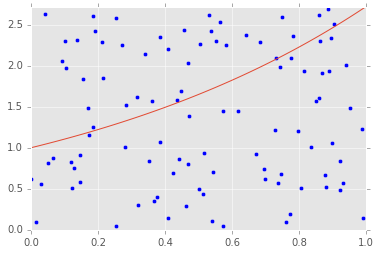

In [6]:
import glob
import matplotlib.pyplot as plt

%matplotlib inline
%precision 4
plt.style.use('ggplot')

x = np.linspace(0, 1, 100)
plt.plot(x, np.exp(x));
pts = np.random.uniform(0,1,(100, 2))
pts[:, 1] *= np.e
plt.scatter(pts[:, 0], pts[:, 1])
plt.xlim([0,1])
plt.ylim([0, np.e]);

In [7]:
# Check analytic solution

from sympy import symbols, integrate, exp

x = symbols('x')
expr = integrate(exp(x), (x,0,1))
expr.evalf()

1.71828182845905

In [8]:
# Using numerical quadrature
# You may recall elementary versions such as the
# trapezoidal and Simpson's rules
# Note that nuerical quadrature needs $n^p$ grid points
# in $p$ dimensions to maintain the same accuracy
# This is known as the curse of dimensionality and explains
# why quadrature is not used for high-dimensional integration

from scipy import integrate
integrate.quad(exp, 0, 1)

(1.7183, 0.0000)

In [9]:
# Monte Carlo approximation

for n in 10**np.array([1,2,3,4,5,6,7,8]):
    pts = np.random.uniform(0, 1, (n, 2))
    pts[:, 1] *= np.e
    count = np.sum(pts[:, 1] < np.exp(pts[:, 0]))
    volume = np.e * 1 # volume of region
    sol = (volume * count)/n
    print('%10d %.6f' % (n, sol))

        10 1.087313
       100 2.065894
      1000 1.701644
     10000 1.704091
    100000 1.720428
   1000000 1.719134
  10000000 1.718470
 100000000 1.718284


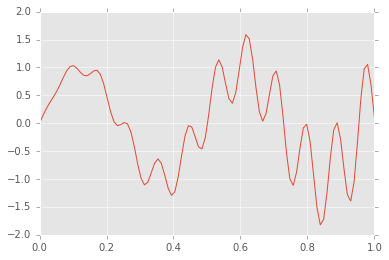

In [10]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)
x = np.linspace(0, 1, 100)
plt.plot(x, f(x));

In [11]:
from sympy import sin, cos, symbols, integrate

x = symbols('x')
integrate(x * cos(71*x) + sin(13*x), (x, 0,1)).evalf(6)

0.0202549

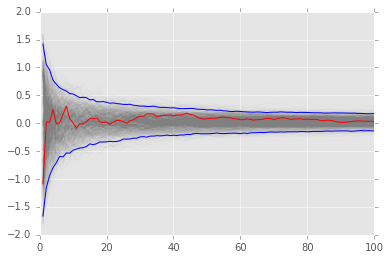

In [12]:
n = 100
reps = 1000
x = f(np.random.random((n, reps)))
y = 1/np.arange(1, n+1)[:, None] * np.cumsum(x, axis=0)
upper, lower = np.percentile(y, [2.5, 97.5], axis=1)

plt.plot(np.arange(1, n+1), y, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), y[:, 0], c='red', linewidth=1);
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b');

In [13]:
xb = np.random.choice(x[:,0], (n, reps), replace=True)
yb = 1/np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)

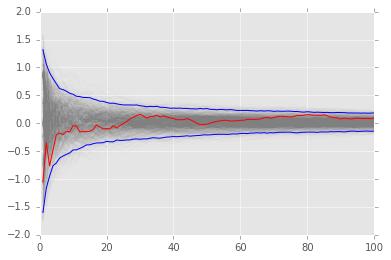

In [14]:
plt.plot(np.arange(1, n+1)[:, None], yb, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), yb[:, 0], c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b');